# Quick Start

Before diving into the core APIs, let's start with a simple example of two
agents creating a plot of Tesla's and Nvidia's stock returns.

We first define the agent classes and their respective procedures for 
handling messages.
We create two agent classes: `Assistant` and `Executor`. The `Assistant`
agent writes code and the `Executor` agent executes the code.
We also create a `Message` data class, which defines the messages that can are passed between
the agents.

```{attention}
Code generated in this example is run within a [Docker](https://www.docker.com/) container. Please ensure Docker is [installed](https://docs.docker.com/get-started/get-docker/) and running prior to running the example. Local code execution is available ({py:class}`~autogen_core.components.code_executor.LocalCommandLineCodeExecutor`) but is not recommended due to the risk of running LLM generated code in your local environment.
```

In [1]:
from dataclasses import dataclass
from typing import List

from autogen_core.base import MessageContext
from autogen_core.components import DefaultTopicId, RoutedAgent, default_subscription, message_handler
from autogen_core.components.code_executor import CodeExecutor, extract_markdown_code_blocks
from autogen_core.components.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)


@dataclass
class Message:
    content: str


@default_subscription
class Assistant(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("An assistant agent.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""Write Python script in markdown block, and it will be executed.
Always save figures to file in the current directory. Do not use plt.show()""",
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\nAssistant:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))  # type: ignore
        await self.publish_message(Message(content=result.content), DefaultTopicId())  # type: ignore


@default_subscription
class Executor(RoutedAgent):
    def __init__(self, code_executor: CodeExecutor) -> None:
        super().__init__("An executor agent.")
        self._code_executor = code_executor

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        code_blocks = extract_markdown_code_blocks(message.content)
        if code_blocks:
            result = await self._code_executor.execute_code_blocks(
                code_blocks, cancellation_token=ctx.cancellation_token
            )
            print(f"\n{'-'*80}\nExecutor:\n{result.output}")
            await self.publish_message(Message(content=result.output), DefaultTopicId())

You might have already noticed, The agents' logic, whether it is using model or code executor,
is completely decoupled from
how messages are delivered. This is the core idea: the framework provides
a communication infrastructure, and the agents are responsible for their own
logic. We call the communication infrastructure an **Agent Runtime**.

Agent runtime is a key concept of this framework. Besides delivering messages,
it also manages agents' lifecycle. 
So the creation of agents are handled by the runtime.

The following code shows how to register and run the agents using 
{py:class}`~autogen_core.application.SingleThreadedAgentRuntime`,
a local embedded agent runtime implementation.


In [2]:
import tempfile

from autogen_core.application import SingleThreadedAgentRuntime
from autogen_core.components.code_executor import DockerCommandLineCodeExecutor
from autogen_core.components.models import OpenAIChatCompletionClient

work_dir = tempfile.mkdtemp()

# Create an local embedded runtime.
runtime = SingleThreadedAgentRuntime()

async with DockerCommandLineCodeExecutor(work_dir=work_dir) as executor:  # type: ignore[syntax]
    # Register the assistant and executor agents by providing
    # their agent types, the factory functions for creating instance and subscriptions.
    await Assistant.register(
        runtime,
        "assistant",
        lambda: Assistant(
            OpenAIChatCompletionClient(
                model="gpt-4o",
                # api_key="YOUR_API_KEY"
            )
        ),
    )
    await Executor.register(runtime, "executor", lambda: Executor(executor))

    # Start the runtime and publish a message to the assistant.
    runtime.start()
    await runtime.publish_message(
        Message("Create a plot of NVIDA vs TSLA stock returns YTD from 2024-01-01."), DefaultTopicId()
    )
    await runtime.stop_when_idle()


--------------------------------------------------------------------------------
Assistant:
```python
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Define the stock tickers
ticker_symbols = ['NVDA', 'TSLA']

# Download the stock data from Yahoo Finance starting from 2024-01-01
start_date = '2024-01-01'
stock_data = yf.download(ticker_symbols, start=start_date)['Adj Close']

# Calculate daily returns
returns = stock_data.pct_change().dropna()

# Plot the stock returns
plt.figure(figsize=(10, 6))
for ticker in ticker_symbols:
    returns[ticker].cumsum().plot(label=ticker)

plt.title('NVIDIA vs TSLA Stock Returns YTD from 2024-01-01')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('nvidia_vs_tsla_stock_returns_ytd_2024.png')
```

--------------------------------------------------------------------------------
Executor:
Traceback (most recent call last):
  File "/workspace/tmp_code_f562

From the agent's output, we can see the plot of Tesla's and Nvidia's stock returns
has been created.

/var/folders/cs/b9_18p1s2rd56_s2jl65rxwc0000gn/T/tmp_9c2ylon


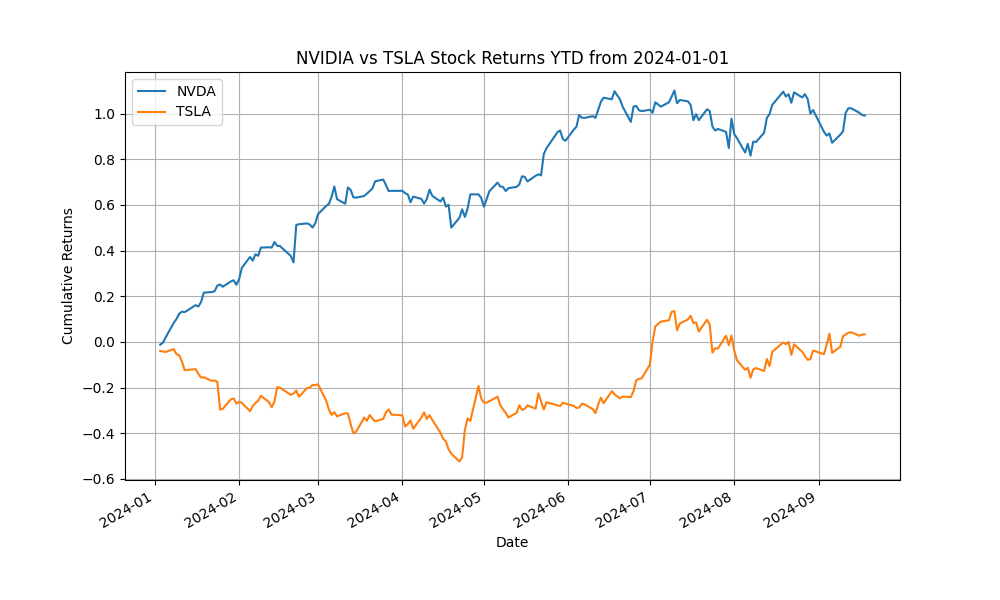

In [4]:
from IPython.display import Image

Image(filename=f"{work_dir}/NVIDIA_vs_TSLA_Stock_Returns_YTD_2024.png")  # type: ignore

AGNext also supports distributed agent runtime, which can host agents running on
different processes or machines, with different identities, languages and dependencies.

To learn how to use agent runtime, communication, message handling, and subscription, please continue
reading the sections following this quick start.